# Autoencoder training

In [1]:
import datetime
import h5py
import keras_preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import tensorflow as tf

from sys import platform
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Convolution2D, AvgPool2D, MaxPooling2D, Convolution2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.metrics import MeanSquaredError, BinaryCrossentropy

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

%matplotlib inline

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.- Loading the dataset.

First, we need to load the images that will be used to train the autoencoder. The function _load_hdf5_files_ takes as inputs a direcotry path in which the hdf5 files with the images are stored, and the number of files to load within that directory. The files are randomly sampled. It returns three numpy arrays, that serve as train, validation and test datasets.

In [3]:
def load_hdf5_files(directory, n = None):
    """
    Load random HDF5 files containing images from a specified directory and concatenate them into a single NumPy array.

    Args:
        directory (str): The path to the directory containing HDF5 files.
        n (int): The number of random files to load.

    Returns:
        train_data: A  NumPy array containing all the images from the train dataset of the loaded HDF5 files.
        validation_data: A single NumPy array containing all the images from the validation dataset of the loaded HDF5 files.
        test_data: A single NumPy array containing all the images from the the test dataset of the loaded HDF5 files.

    The function selects 'n' random HDF5 files from the specified 'directory', reads the datasets from each
    file, and concatenates these datasets into a single NumPy array. This array contains all the images from the loaded
    HDF5 files. The function returns three arrays, one each for training, validation and test.

    Note:
    - Ensure that the HDF5 files in the directory have datasets named 'train', 'validation', and  'test' (or adjust accordingly).
    - If 'n' is greater than the number of available HDF5 files in the directory, all available files will be loaded.
    - if 'n' is not specified, all available files will be loaded

    Example usage:
    >>> directory_path = '/path/to/your/directory'
    >>> n = 3
    >>> train_data, val_data, test_data = load_random_hdf5_files(directory_path, n_files_to_load)
    """

    file_list = []
    # List all HDF5 files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".hdf5"):
            file_list.append(os.path.join(directory, filename))
    if not file_list:
        print("No HDF5 files found in the specified directory.")
        return None
    if (n > len(file_list)) or (n is None):
        print(f"Requested to load {n} files, but there are only {len(file_list)} files available.")
        n = len(file_list)

    # Randomly select n files
    random_files = random.sample(file_list, n)
    train_data = []
    validation_data = []
    test_data = []
    for file_path in random_files:
        with h5py.File(file_path, 'r') as hf:
            d1 = np.array(hf["train"])
            d2 = np.array(hf["validation"])
            d3 = np.array(hf["test"])
            train_data.append(np.array(d1))
            validation_data.append(np.array(d2))
            test_data.append(np.array(d3))
    # Concatenate the individual arrays into a single NumPy array
    train_data = np.concatenate(train_data, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_data = np.concatenate(test_data, axis=0)

    return train_data, validation_data, test_data

In [4]:
if platform == 'darwin':
    images_path = "/Users/lmiguelmartinez/Tesis/datasets/highD/images_1000ms"
else:
    images_path = "/home/lmmartinez/Tesis/datasets/highD/images_1000ms"

train_data, val_data, test_data = load_hdf5_files(images_path, n = 1)

/var/folders/wd/m_272rg54lgflvcghpr2vnsc0000gn/T/ipykernel_10298/3712047877.py:48: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  d1 = np.array(hf["train"])
/var/folders/wd/m_272rg54lgflvcghpr2vnsc0000gn/T/ipykernel_10298/3712047877.py:49: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  d2 = np.array(hf["validation"])
/var/folders/wd/m_272rg54lgflvcghpr2vnsc0000gn/T/ipykernel_10298/3712047877.py:50: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  d3 = np.array(hf["test"])


In [4]:
os.makedirs('/tmp/logs', exist_ok=True)
tensorboard_log_dir = '/tmp/logs/'

In [8]:
IMAGE_SIZE = train_data[0].shape
BATCH_SIZE = 256
print("Images are of size {}".format(IMAGE_SIZE))

Images are of size (121, 201)


### 1.1 Data Inspection

Once the data has been loaded, a few sample images are plotted to verify its integrity.

Total training  images: 8373
Total validation images: 2791
Total test images: 2791


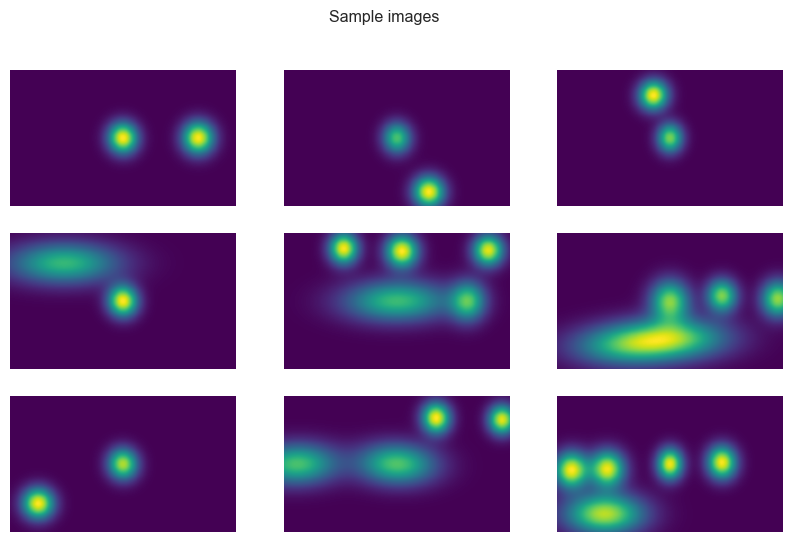

In [5]:
print('Total training  images:', len(train_data))
print('Total validation images:', len(val_data))
print('Total test images:', len(test_data))

plot_size = 3
pic_index = np.random.randint(plot_size, np.min([len(train_data), len(val_data), len(test_data)]))

next_train = [img for img in train_data[pic_index-plot_size:pic_index]]
next_val = [img for img in val_data[pic_index-plot_size:pic_index]]
next_test = [img for img in test_data[pic_index-plot_size:pic_index]]

plt.figure(figsize=(10, 6))
for i, img in enumerate(next_train+next_val+next_test):
    plt.subplot(3, plot_size, i+1)
    plt.imshow(img, cmap = 'viridis')
    plt.axis('Off')
plt.suptitle("Sample images")
plt.show()

## 2.- Model definition.

To define the autoencoder we will use four dictionaries: encoder-decoder architecture, training configuration and model parameters. The class AutoEncoder implements the necessary steps to train the Autoencoder and perform validation and testing tasks.

In [2]:
class AutoEncoder:
    def __init__(self, train_data, val_data, train_config = None, model_config = None, encoder_config = None, decoder_config = None):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.train_config = train_config
        self.encoder_config = encoder_config
        self.decoder_config = decoder_config
        self.model_config = model_config

        self.encoder = None
        self.decoder = None

    def buildModel(self, arch_config = None):
        inputs = layers.Input(shape = self.train_data[0].shape)
        x = inputs
        for layer in arch_config.keys():
            layer_identifier = re.split('_',layer)[0]
            layer_callable = arch_config[layer]['Type']
            if (layer_identifier == 'LSTM'):
                x = layer_callable(arch_config[layer]['Units'], activation = arch_config[layer]['Activation'], return_sequences = arch_config[layer]['return_sequences'], name = layer)(x)
            elif (layer_identifier == 'GRU'):
                x = layer_callable(arch_config[layer]['Units'], activation = arch_config[layer]['Activation'], return_sequences = arch_config[layer]['return_sequences'], name = layer)(x)
            elif (layer_identifier == 'Conv2D'):
                x = layer_callable(filters = arch_config[layer]['Filters'], kernel_size = arch_config[layer]['Kernel size'], strides = arch_config[layer]['Strides'], activation = arch_config[layer]['Activation'], name = layer)(x)
            elif (layer_identifier == 'MaxPooling2D'):
                pass
            elif (layer_identifier == 'AvgPooling2D'):
                pass
            elif (layer_identifier == 'Deconv2D'):
                pass
            elif layer_identifier == ('Dense'):
                if arch_config[layer]['Activation'] is not None:
                    x = layer_callable(arch_config[layer]['Units'], activation = arch_config[layer]['Activation'], name = layer)(x)
                else:
                    x = layer_callable(arch_config[layer]['Units'], name = layer)(x)
            elif (layer_identifier == 'Dropout'):
                x = layer_callable(arch_config[layer]['Value'], name = layer)(x)
            elif (layer_identifier == 'BatchNormalization'):
                x = layer_callable(momentum = arch_config[layer]['Value'], name = layer)(x)

    def compileModel(self):
        loss_fun = self.model_config['loss']
        opt = self.model_config['opt']
        if self.model_config['metric'] is not None:
            metric = self.model_config['metric']
        name = self.model_config['name']
        print("Loss, optimizer and metric set up")
        self.model._name = name
        self.model.compile(loss = loss_fun, optimizer = opt, metrics = metric)
        print("Model created:")
        self.model.summary()
        print("Model has been built")
        self.model = keras.Model(self.encoder, self.decoder)

    def trainModel(self):
        batch_size = self.train_config['batch_size']
        epochs = self.train_config['epochs']
        shuffle = self.train_config['shuffle']
        patience = self.train_config['ES_patience']
        min_delta = self.train_config['ES_min_delta']
        verbose = self.train_config['verbose']

        earlyStopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        verbose=1,
        min_delta = min_delta,
        restore_best_weights = True)

        self.history = self.model.fit(
            x=self.train_data,
            y=self.train_pred,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_data=(self.val_data, self.val_pred),
            shuffle=shuffle,
            callbacks = earlyStopping,
            steps_per_epoch=None,
            validation_freq=1,
        )
        
    def plot_history(self):
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        plt.figure(figsize=(14, 4))
        plt.subplot(1, 2, 1)
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(loss, label='Training set')
        plt.plot(val_loss, label='Validation set', linestyle='--')
        plt.legend()
        plt.grid(linestyle='--', linewidth=1, alpha=0.5)

        # plt.subplot(1, 2, 2)
        # plt.title('Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.plot(accuracy, label='Training set')
        # plt.plot(val_accuracy, label='Validation set', linestyle='--')
        # plt.legend()
        # plt.grid(linestyle='--', linewidth=1, alpha=0.5)

        plt.show()

In [ ]:
model_config = {'name': "FullyConnected1", 'loss': 'mean_squared_error', 'opt': 'adam', 'metric': BinaryCrossentropy}

encoder_config = {
    'Conv2D_1': {'Type': Convolution2D, 'Filters': 32, 'Kernel size': (5,5), 'Strides': (3,3), 'Activation': relu}
    'Dense2': {'Type': Dense, 'Units': 1, 'Activation': None}
}

decoder_config = {
    'Dense1': {'Type': Dense, 'Units': 64, 'Activation': relu},
    'Dense2': {'Type': Dense, 'Units': 1, 'Activation': None}
}

x = layer_callable(filters = arch_config[layer]['Filters'], kernel_size = arch_config[layer]['Kernel size'], strides = arch_config[layer]['Strides'], activation = arch_config[layer]['Activation'])

train_config = {'batch_size': BATCH_SIZE, 'epochs': 200, 'shuffle': True, 'ES_patience': 10, 'ES_min_delta': 1e-2, 'verbose': 0}

autoencoder = AutoEncoder(train_data=)